In [127]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
%pylab inline

## Load simple dataset

We load the data from the UCR TS archive, you can get the data at http://www.cs.ucr.edu/~eamonn/time_series_data/

In [128]:
datapah = '/media/sf_VBox_Shared/timeseries/UCR_TS_Archive_2015'

In [129]:
path_to_data_train = datapah + '/ECG200/ECG200_TRAIN'
path_to_data_test = datapah + '/ECG200/ECG200_TEST'
data_train = np.genfromtxt(path_to_data_train, delimiter=',')
data_test = np.genfromtxt(path_to_data_test, delimiter=',')
print(data_train.shape, data_test.shape)

(100, 97) (100, 97)


In [130]:
X_train = data_train[:,1:]
y_train = np.array(data_train[:,0], dtype='int')
X_test = data_test[:,1:]
y_test = np.array(data_test[:,0], dtype='int')

In [131]:
#Change class labels 
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')

In [132]:
ntrain = X_train.shape[0]
num_training = int(ntrain * 0.7)
num_validation = ntrain - num_training
num_test = data_test.shape[0]
#num_dev = 500

#First sort the data in random order
np.random.seed(123)
neworder = np.random.permutation(ntrain)
X_train_random = X_train[neworder,:]
y_train_random = y_train[neworder]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train_random[mask]
y_val = y_train_random[mask]
mask = range(num_training)
X_train = X_train_random[mask]
y_train = y_train_random[mask]


print(X_val.shape)

(30, 96)


In [133]:
xdim = X_train.shape[1]
outputdim = len(set(y_train))

In [134]:
# We need to convert the output
from keras.utils.np_utils import to_categorical
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)
print(y_train_binary[:10,:])

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


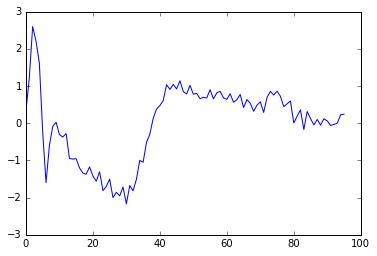

In [155]:
#plot example series
plt.plot(X_train[0,:]);

## Build model architecture

In [135]:
model = Sequential()

In [136]:
model.add(Dense(output_dim=30, input_dim=xdim)) # Fully connected layer
model.add(Activation('relu')) # Relu activation
model.add(Dense(output_dim=outputdim))
model.add(Activation("softmax")) # Final classification layer

Now we configure the learning process:

In [137]:
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), metrics=['accuracy'])

## Fit the model on the data

In [138]:
model.fit(X_train, y_train_binary, nb_epoch=5, batch_size=10)

Epoch 1/5
70/70 [==============================] - 0s - loss: 0.6066 - acc: 0.7286     
Epoch 2/5
70/70 [==============================] - 0s - loss: 0.4795 - acc: 0.7286     
Epoch 3/5
70/70 [==============================] - 0s - loss: 0.3156 - acc: 0.8429     
Epoch 4/5
70/70 [==============================] - 0s - loss: 0.2717 - acc: 0.9000     
Epoch 5/5
70/70 [==============================] - 0s - loss: 0.2525 - acc: 0.9143     


## Validate the model on validation set

In [139]:
loss_and_metrics = model.evaluate(X_val, y_val_binary, batch_size=32)
loss_and_metrics

30/30 [==============================] - 0s


[0.36610609292984009, 0.86666667461395264]

In [140]:
classes = model.predict_classes(X_val, batch_size=32)
proba = model.predict_proba(X_val, batch_size=32)

30/30 [==============================] - 0s


In [141]:
print(np.hstack((proba, np.vstack((classes, y_val)).transpose())))

[[ 0.72325391  0.27674609  0.          0.        ]
 [ 0.99645591  0.00354407  0.          0.        ]
 [ 0.15985902  0.840141    1.          1.        ]
 [ 0.97438711  0.0256129   0.          0.        ]
 [ 0.93279368  0.06720635  0.          1.        ]
 [ 0.99567193  0.00432808  0.          0.        ]
 [ 0.36179492  0.63820505  1.          1.        ]
 [ 0.51744241  0.48255759  0.          1.        ]
 [ 0.98752171  0.01247828  0.          0.        ]
 [ 0.99253607  0.00746394  0.          0.        ]
 [ 0.29819861  0.70180142  1.          1.        ]
 [ 0.88524991  0.11475008  0.          0.        ]
 [ 0.99460334  0.00539666  0.          0.        ]
 [ 0.43065324  0.56934673  1.          1.        ]
 [ 0.99341953  0.00658047  0.          0.        ]
 [ 0.82224762  0.17775239  0.          0.        ]
 [ 0.73466146  0.26533851  0.          0.        ]
 [ 0.99602997  0.00397002  0.          0.        ]
 [ 0.23833109  0.76166892  1.          1.        ]
 [ 0.59787428  0.40212572  0.  

Let's compute some more metrics, such as the confusion matrix and the ROC curve

In [142]:
from sklearn import metrics
metrics.confusion_matrix(classes, y_val)

array([[18,  4],
       [ 0,  8]])

Populating the interactive namespace from numpy and matplotlib


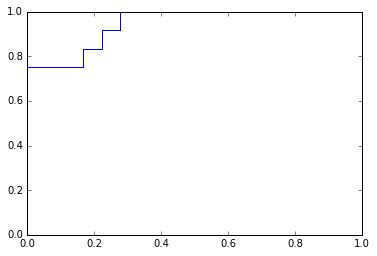

In [153]:
fpr, tpr, _ = metrics.roc_curve(y_val, proba[:,1])
plt.plot(fpr, tpr);